![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Higher-order DMD

Sometimes, it is not possible to approximate the temporal evolution of the state with linear dynamics, e.g., because we only have access to a limited view/observation of the state. In such a scenario, it is still possible to linearize the dynamics by extending the observed state. The higher-order DMD (HODMD), introduced by [Le Clainche et al. (2017)](https://doi.org/10.1137/15M1054924), employs time delay embeddings to extend state. To limit the size increase introduced by the time delays, the data matrix is projected on the first $r$ POD modes before creating the embedding. This notebook reproduces a simple 1D example from the original article (signal (3.5) from section 3.1).

## Creating the test data

In [1]:
from math import sqrt, log
from numpy import pi
import torch as pt
import matplotlib.pyplot as plt
from flowtorch.analysis import DMD, HODMD

# increase resolution of plots
plt.rcParams['figure.dpi'] = 160

The test signal is defined as (see eq. (3.5)):
$$
    f(t) = \sqrt{1+\frac{1}{2}\sin{(t)}\sin{(\sqrt{2}t)}}
$$
The two frequencies inherent to the nonlinear system are $1/(2\pi)$ and $\sqrt{2}/(2\pi)$.
We create a dataset consisting of $3000$ samples. The first $2000$ samples are used to compute the DMD, and the remaining data are used for validation. 

In [2]:
def test_signal(time):
    return pt.sqrt(1 + 0.5*pt.sin(time)*pt.sin((sqrt(2)*time)))

In [3]:
n_train, n_val = 2000, 1000
t_end = 32
t_train = pt.linspace(0, t_end, n_train)
dt = t_train[1] - t_train[0]
t_val = pt.linspace(t_end, t_end+n_val*dt, n_val)
f_train = test_signal(t_train)
f_val = test_signal(t_val)

## Comparison of DMD and HODMD
First, we reproduce the results from the original article using DMD and HODMD with the settings suggested in the reference. Since the data come from a scalar signal, the data must be reshaped into a matrix with one row (a row vector).

In [4]:
dm = f_train.reshape((1, n_train))
dmd = DMD(dm, dt)
hodmd = HODMD(dm[:, :2000], dt, rank_dr=1, rank=27, delay=800)
dmd_val = dmd.predict(f_train[-1].reshape((1, 1)), n_val-1)
hodmd_val = hodmd.predict(dm[:, -800:], n_val-1)

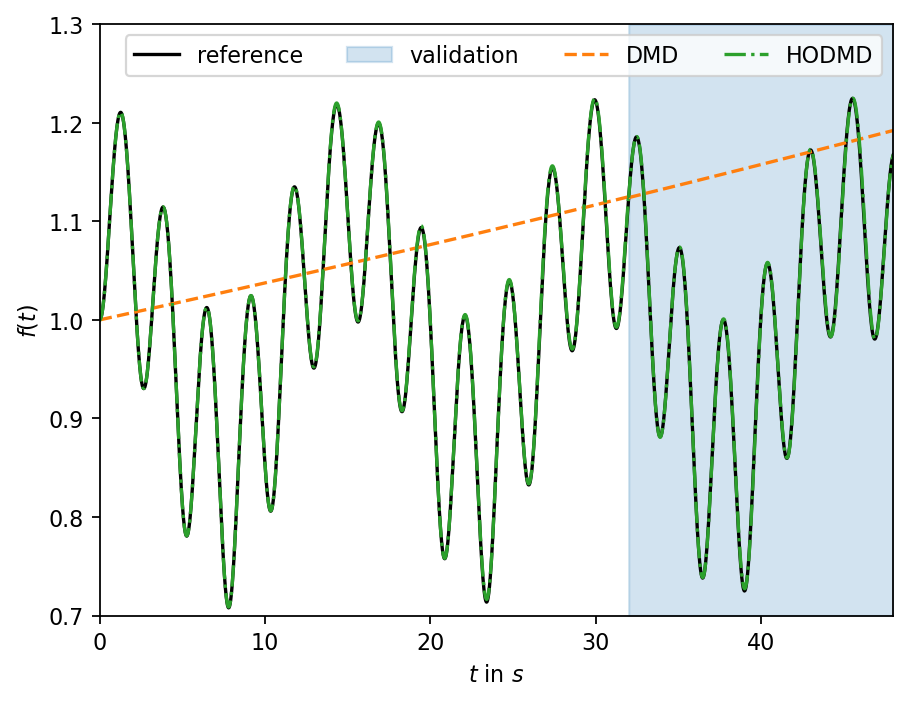

In [5]:
fig, ax, = plt.subplots()

ax.plot(t_train, f_train, c="k", ls="-", label="reference")
ax.fill_between(t_val, 0.7, 1.3, color="C0", alpha=0.2, label="validation")
ax.plot(t_val, f_val, c="k", ls="-")
ax.plot(t_train, dmd.reconstruction.squeeze(), c="C1", ls="--", label="DMD")
ax.plot(t_train, hodmd.reconstruction.squeeze(), c="C2", ls="-.", label="HODMD")
ax.plot(t_val, dmd_val.squeeze(), c="C1", ls="--")
ax.plot(t_val, hodmd_val.squeeze(), c="C2", ls="-.")

ax.set_xlim(0, t_val[-1])
ax.set_ylim(0.7, 1.3)
ax.legend(ncol=4)
ax.set_xlabel(r"$t$ in $s$")
ax.set_ylabel(r"$f(t)$")
plt.show()

Next, we inspect the frequencies found by the HODMD and compare them to the frequencies used to create the data. As can been in the plot above, the HODMD creates an accurate approximation of the true dynamical system. However, the HODMD finds a different set of more than two frequencies to create the approximation. The two pronounced frequencies with the highest amplitude are distinct from the ones of the underlying nonlinear dynamical system.

In [6]:
fr = hodmd.frequency
pos = fr > 1e-3
fr = fr[pos]
a = hodmd.amplitude[pos].abs()

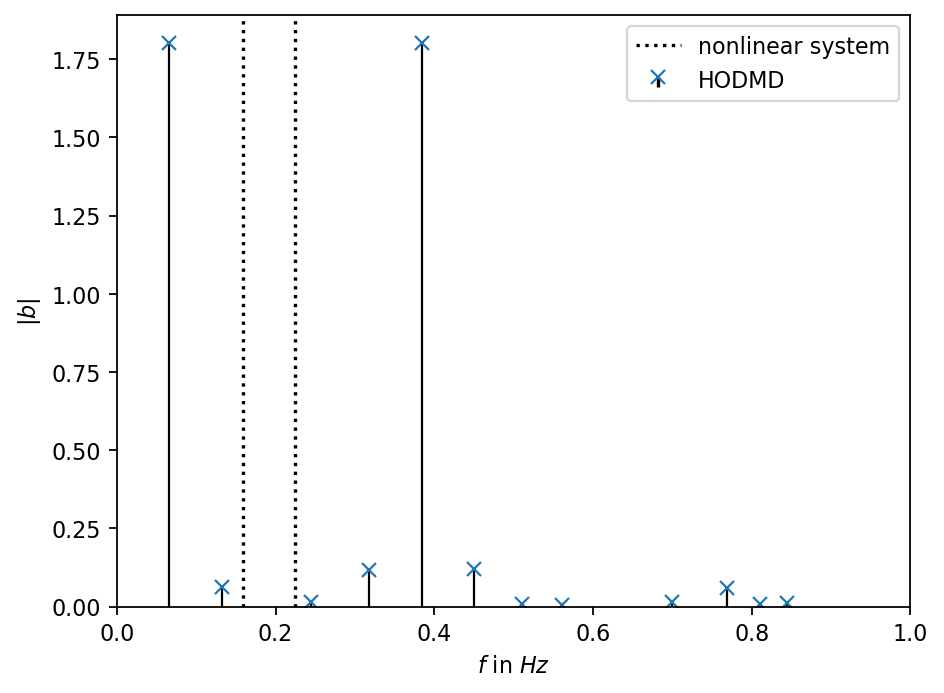

In [7]:
fig, ax = plt.subplots()

markerline, stemlines, baseline = ax.stem(fr.numpy(), a.numpy(), basefmt="none", linefmt=f"k-", markerfmt="x", label="HODMD")
plt.setp(stemlines, "linewidth", 1)
plt.setp(markerline, markersize=6)
ax.axvline(1/(2*pi), c="k", ls=":", label="nonlinear system")
ax.axvline(sqrt(2)/(2*pi), c="k", ls=":")
ax.set_xlim(0, 1.0)
ax.set_ylim(0)
ax.set_xlabel(r"$f$ in $Hz$")
ax.set_ylabel(r"$|b|$")
ax.legend()
plt.show()

## Sensitivity to hyperparameters

For this 1D system, there are only two hyperparameter to tune the HODMD, namely the number of time delays (`delay`) and the number of modes to keep (`rank`). For high-dimensional data, the number of POD modes on which to project the data (`rank_dr`) is an additional degree of freedom. The original reference article suggests using approximately one-third of the number of snapshots as the number of delays, which would be around $d=667$ for the present dataset. To get an intuition for the sensitivity to rank and delay parameters, we perform a parameter study and visualize the error norms for training and validation data. Relative errors larger than $100\%$ are set to `nan`.

In [8]:
delays = list(range(2, 1600, 5))
ranks = list(range(1, 51, 1))
error_map_train = pt.zeros((len(delays), len(ranks)))
error_map_val = pt.zeros((len(delays), len(ranks)))
norm_train, norm_val = f_train.norm(), f_val.norm()
opt_rank = []
count, total = 1, len(delays)*len(ranks)
for i, d in enumerate(delays):
    for j, r in enumerate(ranks):
        print(f"\rTesting configuration {count:4d}/{total:4d}", end="")
        if r <= d:
            hodmd = HODMD(dm[:, :2000], dt, rank_dr=1, rank=r, delay=d)
            rec_err = hodmd.reconstruction_error.norm() / norm_train
            error_map_train[i, j] = rec_err if rec_err < 1.0 else pt.nan
            val_err = (f_val - hodmd.predict(dm[:, -d:], n_val-1)).norm() / norm_val
            error_map_val[i, j] = val_err if val_err < 1.0 else pt.nan
            if r == ranks[0]:
                opt_rank.append(hodmd.svd.opt_rank)
        else:
            error_map_train[i, j] = pt.nan
            error_map_val[i, j] = pt.nan
        count += 1

Testing configuration 16000/16000

The error maps below show the following trends:
- both maps yield qualitatively the same results; the training errors are slightly lower on average
- there exists a range $600 < d < 1200$ and $20 < r < 35$ in which the error is consistenly low
- small values of $r$ lead to larger errors; however, the outcomes are never extreme
- larger values of $r$ lead to extreme outcomes (overfitting); the singular value hard thresholding (SVHT) algorithm consistently yields ranks that are too large (for the present dataset); taking about $50\%$ of the SVHT rank seems to be a better choice
- increasing the number of time delays reduces the error up to the point that the Hankel matrix's number of columns becomes larger than the number of snapshots; for values of approximately $d>1200$, the error starts to increase again

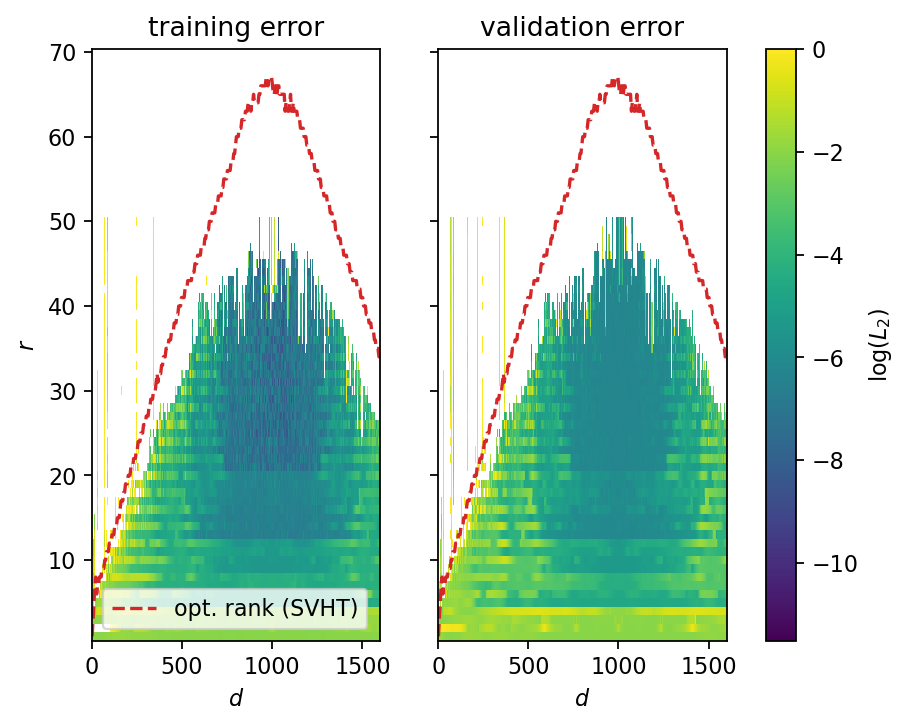

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
dd, rr = pt.meshgrid(pt.tensor(delays), pt.tensor(ranks), indexing="ij")
ax1.pcolormesh(dd, rr, error_map_train.log().numpy(), vmin=log(1e-5), vmax=0)
cont2 = ax2.pcolormesh(dd, rr, error_map_val.log().numpy(), vmin=log(1e-5), vmax=0)
plt.colorbar(cont2, ax=(ax1, ax2), label=r"$\mathrm{log}(L_2)$")
ax1.plot(delays, opt_rank, ls="--", c="C3", label="opt. rank (SVHT)")
ax2.plot(delays, opt_rank, ls="--", c="C3")
ax1.legend()
ax1.set_title("training error")
ax2.set_title("validation error")
ax1.set_xlabel(r"$d$")
ax2.set_xlabel(r"$d$")
ax1.set_ylabel(r"$r$")
plt.show()